# Análise de Risco de Inadimplência de Clientes

Segue-se um relatório que poderia ser destinado para a divisão de empréstimos de um banco.
A ideia aqui é tratar os dados para responder algumas perguntas.
* Será que o estado civil de um cliente e o número de filhos têm impacto sobre a inadimplência nos empréstimos realizados?
* Existem motivações para adquirir empréstimos mais arriscadas que outras?
* O nível de renda afeta os pagamentos de empréstimos em dia?
* Como a finalidade do crédito afeta a taxa de inadimplência?

O banco já tem alguns dados sobre a capacidade de crédito dos clientes.

# Índice <a id='back'></a>

1. [Exploração de Dados](#1)
    * [Conclusões](#1C)
2. [Transformação de Dados](#2)
3. [Trabalhando com valores ausentes](#3)
    * [Restaurar valores ausentes em `total_income`](#31)
    * [Restaurar valores ausentes em `days_employed`](#32)
4. [Categorização de Dados](#4)
5. [Verificar as Hipóteses](#5)
6. [Conclusão Geral](#6)
7. [REFERÊNCIAS](#end)

In [1]:
# Carregando todas as bibliotecas e abrir o local do arquivo
import pandas as pd
import datetime as dt
import numpy as np
# Carregue os dados
import os;
os.listdir('/kaggle/input/')
df = pd.read_csv('/kaggle/input/credit-scoring/credit_scoring_eng.csv')

## 1. Exploração de Dados <a id='1'></a>

**Descrição dos dados**
- `children` - o número de crianças na família
- `days_employed` - experiência de trabalho em dias
- `dob_years` - idade do cliente em anos
- `education` - educação do cliente
- `education_id` - identificador de educação
- `family_status` - estado civil do cliente
- `family_status_id` - identificador de estado civil
- `gender` - gênero do cliente
- `income_type` - tipo de emprego
- `debt` - havia alguma dívida no pagamento do empréstimo
- `total_income` - renda mensal
- `purpose` - o objetivo de obter um empréstimo

Agora vamos explorar nossos dados para verificar possíveis problemas com eles.

[Voltar ao Índice](#back)

In [2]:
# Verificar quantas linhas e colunas nosso conjunto de dados tem
print(f'O DataFrame contém {df.shape[0]} linhas e {df.shape[1]} colunas.')

O DataFrame contém 21525 linhas e 12 colunas.


In [3]:
# vamos exibir as primeiras N linhas
display(df.head(10))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33,Secondary Education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
4,0,340266.072047,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding
5,0,-926.185831,27,bachelor's degree,0,civil partnership,1,M,business,0,40922.170,purchase of the house
6,0,-2879.202052,43,bachelor's degree,0,married,0,F,business,0,38484.156,housing transactions
7,0,-152.779569,50,SECONDARY EDUCATION,1,married,0,M,employee,0,21731.829,education
8,2,-6929.865299,35,BACHELOR'S DEGREE,0,civil partnership,1,F,employee,0,15337.093,having a wedding
9,0,-2188.756445,41,secondary education,1,married,0,M,employee,0,23108.150,purchase of the house for my family


In [4]:
# Verificar as principais variáveis descritivas
display(df.describe())

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,19351.000000
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,26787.568355
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,16475.450632
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,3306.762000
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,16488.504500
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,23202.870000
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,32549.611000
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,362496.645000


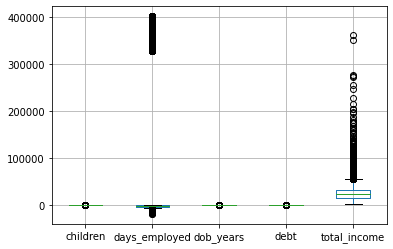

In [5]:
# Explorar os valores discrepantes
boxplot = df.boxplot(column=['children', 'days_employed', 'dob_years', 'debt', 'total_income'])

- `days_employed` e `total_income` são as variáveis que mais precisam atenção no tratamento, seus dados são bem dispersos e possuem ambas desvio padrão muito acentuado.

- Em `children` deve-se avaliar se há valores discrepantes.  Essa variável atinge seu valor máximo em 20 e valor mínimo em -1. Essa variável só deve aceitar valores inteiros e positivos.

- Em `days_employed` há números negativos e valores extremos. A variável é definida como experiência de trabalhos em dias, logo compreende-se que não se deve haver dias negativos e nem mesmo dias fracionados. Essa variável deve ser inteira e positiva. Porém, no mínimo, 75% dos dados são números negativos.

- Em `dob_years` deve-se avaliar se há valores discrepantes. Essa variável só deve aceitar valores inteiros e positivos. Porém assume valor mínimo em 0, assim, deve-se avaliar juntamente com outras variáveis se são dados de contas de clientes com menos de 1 ano de vida — muitos bancos abrem contas de crianças com responsáveis sendo os próprios pais. 

- Em `education` há variáveis qualitativas duplicatas implícitas. A correção pode ser verificada com a variável `education_id`.

- Em `family_status` deve-se avaliar se não há dados duplicados de forma implícita. A correção pode ser verificada com a variável `family_status_id`.

- Em `gender` deve-se avaliar se não há dados duplicados de forma implícita.

- Em `income_type` deve-se avaliar se não há dados duplicados de forma implícita.

- Em `debt` só aceita-se valores 1 ou 0. Para 1 se já deixou de pagar um empréstimo e 0 para quem sempre pagou empréstimo ou nunca adquiriu um.

- Em `total_income` há apenas valores positivos. Uma vez que a renda não pode ser negativa.

- Em `purpose` deve-se avaliar se há alguma variável qualitativa duplicada de forma implícita.

[Voltar ao Índice](#back)

In [6]:
# Obter informações sobre dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


- Há valores ausentes nas variáveis `days_employed` e `total_income`. 

- Em `days_employed`, seus valores ausentes podem estar relacionados a ausência de experiência de trabalho ou falta de resposta. Comparar com a variável `income_type` pode sugerir qual a opção correta.

- Em `total_income` esses valores podem estar ausentes por falta de renda ou recusa em apresentar essas informações por parte dos clientes. É interessante comparar com a variável `income_type` para distinguir entre as duas opções.

In [7]:
# Vejamos a tabela filtrada com valores ausentes na primeira coluna com dados ausentes
display(df[df['days_employed'].isna()])

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,secondary education,1,civil partnership,1,M,retiree,0,NaN,to have a wedding
26,0,NaN,41,secondary education,1,married,0,M,civil servant,0,NaN,education
29,0,NaN,63,secondary education,1,unmarried,4,F,retiree,0,NaN,building a real estate
41,0,NaN,50,secondary education,1,married,0,F,civil servant,0,NaN,second-hand car purchase
55,0,NaN,54,secondary education,1,civil partnership,1,F,retiree,1,NaN,to have a wedding
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Secondary Education,1,married,0,M,business,0,NaN,purchase of a car
21495,1,NaN,50,secondary education,1,civil partnership,1,F,employee,0,NaN,wedding ceremony
21497,0,NaN,48,BACHELOR'S DEGREE,0,married,0,F,business,0,NaN,building a property
21502,1,NaN,42,secondary education,1,married,0,F,employee,0,NaN,building a real estate


Os valores ausentes em `days_employed` e em `total_income` parecem sugerir uma simetria e correlação. Faz sentido quando paramos para pensar que a falta de experiência de trabalho está relacionada a falta de renda. A ausência desses dados pode ser por esse fator. Os testes para comprovar essa suposição serão feitos adiante.

In [8]:
#Verificar se os valores NaN em days_employed correspondem as mesmas linhas em total_income
nan_df = df[df['days_employed'].isna()]
nan_income = nan_df['total_income'].isna().count()
df_nan_income = df['total_income'].isna().sum()
print(f'Num DataFrame criado com os valores nulos em days_employed, a quantidade de linhas com valor nulo em total_income é: {nan_income}. A mesma quantidade de valores NaN no DataFrame original na variável total_income ({df_nan_income})')

Num DataFrame criado com os valores nulos em days_employed, a quantidade de linhas com valor nulo em total_income é: 2174. A mesma quantidade de valores NaN no DataFrame original na variável total_income (2174)


In [9]:
# Verificar o tipo de emprego que os clientes com valores nulos em renda e em dias de trabalho possuem
print(nan_df['income_type'].value_counts())

employee         1105
business          508
retiree           413
civil servant     147
entrepreneur        1
Name: income_type, dtype: int64


In [10]:
# Aplicar várias condições para filtrar dados e observar o número de linhas na tabela filtrada.
(df.isna()
 .mean()
 .sort_values(ascending=False)
 .reset_index()
 .rename(columns = {'index' : 'Variables', 0: 'Missing'})
).T

,0,1,2,3,4,5,6,7,8,9,10,11
Variables,days_employed,total_income,children,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,purpose
Missing,0.100999,0.100999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Conclusão intermediária**

Conclui-se que a tabela filtrada corresponde a mesma quantidade de linhas de valores ausentes para as duas variáveis com valores ausentes, `days_employed` e `total_income`.

Valores ausentes nas duas variáveis correspondem a 10.09% do total de dados das suas respectivas variáveis, um valor bastante expressivo. Nesse sentido, a melhor forma de tratá-los é preencher esses valores ausentes. Assim, é importante considerar características específicas do cliente, como o tipo de emprego, sexo e educação.

Os próximos passos envolvem realizar testes e agrupamentos para verificar se os valores ausentes surgiram de forma aleatória.

[Voltar ao Índice](#back)

**Possíveis motivos para valores ausentes nos dados**

A suposição de que a falta de experiência de dias de trabalho contribui para a falta de renda parece ser verdadeira. Porém há muitos clientes sem experiência de trabalho e sem renda informada que estão empregados, são empresários ou funcionários públicos. Os dados sugerem que as informações desses clientes foram coletados muito cedo, de forma que ainda não computaram experiência e nem renda nos seus tipos de emprego — o que acho improvável. O mais provável é que houve falta de informação intencional, já que renda é um dado sensível.

In [11]:
# Distribuição do conjunto de dados em children
df_children = df['children'].value_counts(dropna=False, normalize=True)
nan_df_children = nan_df['children'].value_counts(dropna=False, normalize=True)
print(df_children - nan_df_children)

-1     0.000804
 0    -0.004585
 1     0.005341
 2     0.001634
 3    -0.001228
 4    -0.001315
 5    -0.000042
 20   -0.000609
Name: children, dtype: float64


In [12]:
# Distribuição do conjunto de dados em dob_years
df_dob_years = df['dob_years'].value_counts(dropna=False, normalize=True)
nan_df_dob_years = nan_df['dob_years'].value_counts(dropna=False, normalize=True)
print(df_dob_years - nan_df_dob_years)

0     0.000092
19    0.000190
20    0.000069
21   -0.003123
22    0.000682
23   -0.004759
24    0.002605
25    0.006006
26    0.002855
27    0.006344
28   -0.002851
29    0.002320
30   -0.001592
31   -0.003883
32    0.006674
33    0.003533
34   -0.003725
35   -0.000774
36   -0.003195
37    0.000569
38    0.002943
39    0.003161
40   -0.002066
41    0.001061
42   -0.002164
43    0.000834
44    0.005173
45    0.000090
46   -0.000012
47   -0.004839
48    0.003835
49    0.000601
50    0.000420
51   -0.002186
52   -0.001894
53    0.001085
54   -0.003046
55   -0.001498
56   -0.002214
57   -0.004388
58   -0.004342
59    0.004988
60   -0.000425
61   -0.000987
62   -0.001126
63   -0.000842
64   -0.004708
65   -0.000187
66   -0.000698
67    0.000399
68    0.000459
69    0.001649
70    0.001640
71    0.000395
72    0.000613
73   -0.000088
74         NaN
75         NaN
Name: dob_years, dtype: float64


In [13]:
# Distribuição do conjunto de dados em education_id
df_education_id = df['education_id'].value_counts(dropna=False, normalize=True)
nan_df_education_id = nan_df['education_id'].value_counts(dropna=False, normalize=True)
print(df_education_id - nan_df_education_id)

0   -0.005863
1   -0.000683
2    0.002826
3    0.003441
4         NaN
Name: education_id, dtype: float64


In [14]:
# Distribuição do conjunto de dados em family_status_id
df_family_status_id = df['family_status_id'].value_counts(dropna=False, normalize=True)
nan_df_family_status_id = nan_df['family_status_id'].value_counts(dropna=False, normalize=True)
print(df_family_status_id - nan_df_family_status_id)

0    0.006148
1   -0.009258
4   -0.001789
3    0.003999
2    0.000901
Name: family_status_id, dtype: float64


In [15]:
# Distribuição do conjunto de dados em gender
df_gender = df['gender'].value_counts(dropna=False, normalize=True)
nan_df_gender = nan_df['gender'].value_counts(dropna=False, normalize=True)
print(df_gender - nan_df_gender)
print()
print(nan_df_gender)

F     -0.021242
M      0.021196
XNA         NaN
Name: gender, dtype: float64

F    0.682613
M    0.317387
Name: gender, dtype: float64


In [16]:
# Distribuição do conjunto de dados em debt
df_debt = df['debt'].value_counts(dropna=False, normalize=True)
nan_df_debt = nan_df['debt'].value_counts(dropna=False, normalize=True)
print(nan_df_debt)
print()
print(df_debt - nan_df_debt)

0    0.921803
1    0.078197
Name: debt, dtype: float64

0   -0.002686
1    0.002686
Name: debt, dtype: float64


A variação das colunas `children`, `dob_years`,`education_id`,`family_status_id`, `debt` do DataFrame original com as mesmas colunas do DataFrame de valores ausentes não chega a 1% em cada um dos seus respectivos elementos. Não há sinais de um padrão na relação que afete os valores ausentes. Na coluna `gender`, apesar de haver um percentual maior de valores ausentes quando analisamos os dados das mulheres, a proporção se mantém quando analisamos a variação dos valores no DataFrame orginal e o DataFrame de valores ausentes.

**Conclusão intermediária**

A distribuição no conjunto de dados original é semelhante à distribuição da tabela filtrada. Pois essa variação não chega a 1%.

Estamos cientes também que todos os valores ausentes na variável `total_income` correspondem a valores ausentes na variável `days_employed`, porém é possível imaginar que certos tipos de empregos (`income_type`) possam contribuir ou favorecer o surgimento de valores ausentes, como para os tipos estudantes e desempregados.

É importante verificar se os clientes que possuem idade igual a zero contribuem para a existência de valores ausentes em experiência em dias de emprego e renda.

[Voltar ao Índice](#back)

In [17]:
# Para valores ausentes provenientes de certos tipos de emprego
print(df['income_type'].value_counts())
print()
# Para valores ausentes provenientes de clientes com idade igual a zero
print(nan_df[nan_df['dob_years']==0].count())

employee                       11119
business                        5085
retiree                         3856
civil servant                   1459
unemployed                         2
entrepreneur                       2
student                            1
paternity / maternity leave        1
Name: income_type, dtype: int64

children            10
days_employed        0
dob_years           10
education           10
education_id        10
family_status       10
family_status_id    10
gender              10
income_type         10
debt                10
total_income         0
purpose             10
dtype: int64


**Conclusão intermediária**

Desse modo, podemos afirmar que os valores ausentes parece serem acidentais quando não levamos em conta a relação entre as variáveis `days_employed` e `total_income`. Nem a presença de clientes com idade igual a zero e nem mesmo a pouca expressividade de valores em tipo de emprego estudante e desempregado na variável `income_type`, foram suficientes para nortear ou sugerir um padrão no surgimento de valores ausentes na base de dados.

**Conclusões** <a id='1C'></a>

As análises realizadas sugerem que não há padrões nos dados que gerem valores ausentes para além da relação estabelecida entre as variáveis `days_employed` e `total_income`. Cada variável do DataFrame foi testada conforme sua distribuição original e a sua distribuição do DataFrame filtrado em valores ausentes, mas não houve variações nos dados superiores a 1%.

Desse modo, as próximas etapas envolvem preencher os valores ausentes em `days_employed` e em `total_income`. Para `days_employed` deve-se tratar os números negativos e valores extremos, a mediana deve-se ajustar melhor que a média. Como a variável é definida como experiência de trabalhos em dias, logo compreende-se que não se deve haver dias negativos e nem mesmo dias fracionados. Essa variável deve ser inteira e positiva.

já em `total_income`, preencher os valores ausentes levando em consideração as variações entre sexo e anos de estudo. Pois estudos sugerem que existem diferenças salariais entre gênero e que a renda aumenta conforme a quantidade de anos de estudo que o indivíduo possui.

Além do preenchimento dos valores ausentes, vai ser imprescindível para uma boa análise, o tratamento de duplicatas, diferença de registros e de valores incorretos.

[Voltar ao Índice](#back)

## 2. Transformação de Dados <a id='2'></a>

O objetivo é analisar as colunas, variáveis, para identificar possíveis problemas como duplicatas.

In [18]:
# Verificar todos os valores na coluna de educação para ver quais grafias precisarão ser corrigidas
print(df['education'].sort_values().unique())

["BACHELOR'S DEGREE" "Bachelor's Degree" 'GRADUATE DEGREE'
 'Graduate Degree' 'PRIMARY EDUCATION' 'Primary Education'
 'SECONDARY EDUCATION' 'SOME COLLEGE' 'Secondary Education' 'Some College'
 "bachelor's degree" 'graduate degree' 'primary education'
 'secondary education' 'some college']


In [19]:
# Corrigindo os registros
df['education'] = df['education'].str.lower()

In [20]:
# Verificar todos os valores na coluna para ter certeza de que houve a correção
print(df['education'].sort_values().unique())

["bachelor's degree" 'graduate degree' 'primary education'
 'secondary education' 'some college']


In [21]:
# Verificando a distribuição de valores na coluna `children`
print(df['children'].value_counts(dropna=False, normalize=True))
print(df['children'].shape[0])

 0     0.657329
 1     0.223833
 2     0.095470
 3     0.015331
 20    0.003531
-1     0.002184
 4     0.001905
 5     0.000418
Name: children, dtype: float64
21525


A porcentagem de dados problemáticos da variável `children` é a soma do percentual quando há 20 (0.35%) e -1 (0.21%) filhos, aproximadamente 0.57%. Apesar dos erros serem bem baixos na variável, é de fácil entendimento que o erro está relacionado com o sinal negativo em -1, pois não há filhos negativos, e um adicional de um zero em 20, dese modo, faço os seguintes ajustes:

count    21525.000000
mean         0.479721
std          0.755528
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: children, dtype: float64

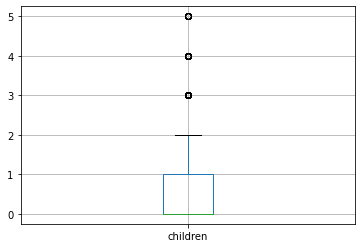

In [22]:
df['children'] = df['children'].replace(20,2) # Considero que o outlier 20 seja um erro de digitação
df['children'] = df['children'].replace(-1,1) # Considero que o número negativo de filhos seja um erro de digitação
boxplot = df.boxplot(column='children') # Visualizar dados discrepantes
display(df['children'].describe())

In [23]:
# Verificar a coluna `children` novamente para ter certeza de que está tudo corrigido
df['children'] = df['children'].astype('int')
print(df['children'].value_counts())

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64


Na variável idade em anos do cliente, `dob_years`, temos valores 0 (zero) em algumas poucas linhas, mas é importante tratá-los, pois essa variável servirá para corrigir valores em `days_employed`. Desse modo, a melhor forma de corrigir é utilizando a média inteira para substituir os valores nulos.

Num primeiro momento foi pensado que poderia tratar-se de crianças que ainda não tinham 1 ano de vida, porém outras variáveis dessas linhas sugerem se tratar de erro de inserção de valores, uma vez que muitas linhas de idade 0 (zero) estão como empregados, aposentados e níveis educacionais mais avançados.

[Voltar ao Índice](#back)

In [24]:
# Corrigir as idades 0 em dob_years
df['dob_years'] = np.where(df['dob_years']==0, np.nan, df['dob_years'])
# Definir a média em dob_years, valores inteiros
mean_dob_years = int((df['dob_years']).mean())
# Substituir valores ausentes pela média inteira de dob_years
df['dob_years'].fillna(int(df['dob_years'].mean()), inplace = True)

In [25]:
# Checar se ainda há valores ausentes
print(df['dob_years'].isna().mean())

0.0


In [26]:
# Verificar o resultado
print(len(df[df['dob_years']==0]))
print()
print(df['dob_years'].describe())

0

count    21525.000000
mean        43.495145
std         12.218213
min         19.000000
25%         34.000000
50%         43.000000
75%         53.000000
max         75.000000
Name: dob_years, dtype: float64


Em `days_employed` temos valores ausentes, números extremos — dias de trabalho que superam os dias de vida dos clientes —, bem como números negativos (não há dias trabalhados negativos).

In [27]:
# Dados problemáticos, valores negativos
df_neg_days = df.loc[df.loc[:,'days_employed']<0]
display(df_neg_days)
print('='*100)
perc_neg_days = df_neg_days['days_employed'].shape[0] / df['days_employed'].shape[0]
print(f'A porcentagem de valores negativos é {perc_neg_days:.2%}.')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42.0,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house
1,1,-4024.803754,36.0,secondary education,1,married,0,F,employee,0,17932.802,car purchase
2,0,-5623.422610,33.0,secondary education,1,married,0,M,employee,0,23341.752,purchase of the house
3,3,-4124.747207,32.0,secondary education,1,married,0,M,employee,0,42820.568,supplementary education
5,0,-926.185831,27.0,bachelor's degree,0,civil partnership,1,M,business,0,40922.170,purchase of the house
...,...,...,...,...,...,...,...,...,...,...,...,...
21519,1,-2351.431934,37.0,graduate degree,4,divorced,3,M,employee,0,18551.846,buy commercial real estate
21520,1,-4529.316663,43.0,secondary education,1,civil partnership,1,F,business,0,35966.698,housing transactions
21522,1,-2113.346888,38.0,secondary education,1,civil partnership,1,M,employee,1,14347.610,property
21523,3,-3112.481705,38.0,secondary education,1,married,0,M,employee,1,39054.888,buying my own car


A porcentagem de valores negativos é 73.90%.


In [28]:
#Corrigir valores negativos
df['days_employed'] = abs(df['days_employed']) # Transformando esses valores em valores absolutos
df_neg_days = df.loc[df.loc[:,'days_employed']<0] # Verificando se a correção foi feita
display(df_neg_days.count())

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

In [29]:
# Dados problemáticos, dias trabalhados superiores aos dias de vida
df_outlier_days = df.loc[df.loc[:,'days_employed']>(df['dob_years']*365)] # Aplicando a lógica
display(df_outlier_days)
print('='*100)
# Mostrando o percentual de valores extremos
perc_outlier_days = df_outlier_days['days_employed'].shape[0] / df['days_employed'].shape[0]
print(f'A porcentagem de dias trabalhados que superam a idade do cliente é {perc_outlier_days:.2%}.')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
4,0,340266.072047,53.0,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding
18,0,400281.136913,53.0,secondary education,1,widow / widower,2,F,retiree,0,9091.804,buying a second-hand car
24,1,338551.952911,57.0,secondary education,1,unmarried,4,F,retiree,0,46487.558,transactions with commercial real estate
25,0,363548.489348,67.0,secondary education,1,married,0,M,retiree,0,8818.041,buy real estate
30,1,335581.668515,62.0,secondary education,1,married,0,F,retiree,0,27432.971,transactions with commercial real estate
...,...,...,...,...,...,...,...,...,...,...,...,...
21505,0,338904.866406,53.0,secondary education,1,civil partnership,1,M,retiree,0,12070.399,to have a wedding
21508,0,386497.714078,62.0,secondary education,1,married,0,M,retiree,0,11622.175,property
21509,0,362161.054124,59.0,bachelor's degree,0,married,0,M,retiree,0,11684.650,real estate transactions
21518,0,373995.710838,59.0,secondary education,1,married,0,F,retiree,0,24618.344,purchase of a car


A porcentagem de dias trabalhados que superam a idade do cliente é 16.00%.


In [30]:
# Analisar os dados problemáticos, dias de trabalhos superiores ao dias de vida
display(df_outlier_days.groupby('income_type')['days_employed'].count())
print()
display(df.groupby('income_type')['days_employed'].count())

income_type
retiree       3443
unemployed       2
Name: days_employed, dtype: int64

income_type
business                        4577
civil servant                   1312
employee                       10014
entrepreneur                       1
paternity / maternity leave        1
retiree                         3443
student                            1
unemployed                         2
Name: days_employed, dtype: int64

Os clientes com informações de dias trabalhados que superam seus dias de vida estão concentrados, em sua totalidade, no grupo `retiree`.
Até 2022, para se aposentar nos Estados Unidos era necessário trabalhar por no mínimo 10 anos e ter 62 anos ou mais. Apesar de ser possível trabalhar com menos de 18 anos nos Estados Unidos, esses trabalhos raramente recolhem impostos ou possuem contratos que garantem os critérios para se aposentar. Desse modo, os valores a serem substituídos em `days_employed` devem variar entre 3650 e a multiplicação de 365 dias com idade atual do cliente menos 18 anos — (`dob_years` - 18)*365.

[Voltar ao Índice](#back)

In [31]:
# Encontrar a média e a mediana de days_employed desconsiderando os valores extremos
dif_days = df.loc[df.loc[:,'days_employed']<(df['dob_years']*365)]
values_dmean_employed = dif_days.groupby('income_type')['days_employed'].mean()
display(values_dmean_employed)
values_dmedian_employed = dif_days.groupby('income_type')['days_employed'].median()
display(values_dmedian_employed)

income_type
business                       2111.524398
civil servant                  3399.896902
employee                       2326.499216
entrepreneur                    520.848083
paternity / maternity leave    3296.759962
student                         578.751554
Name: days_employed, dtype: float64

income_type
business                       1547.382223
civil servant                  2689.368353
employee                       1574.202821
entrepreneur                    520.848083
paternity / maternity leave    3296.759962
student                         578.751554
Name: days_employed, dtype: float64

In [32]:
# Criar função para substituir valores
def preencher_days_employed(row):
    if row['income_type']=='retiree' or row['income_type']=='unemployed':
        max_day = (row['dob_years']*365-(18*365))
        return max_day
    else:
        return row['days_employed']

In [33]:
# Testar a função com a primeira linha dos valores extremos
df[df['days_employed']>(df['dob_years']*365)].iloc[0]

children                              0
days_employed             340266.072047
dob_years                          53.0
education           secondary education
education_id                          1
family_status         civil partnership
family_status_id                      1
gender                                F
income_type                     retiree
debt                                  0
total_income                  25378.572
purpose               to have a wedding
Name: 4, dtype: object

In [34]:
# Testar a função, o resultado deve ser (53-18)*365 = 12775
preencher_days_employed(df[df['days_employed']>(df['dob_years']*365)].iloc[0])

12775.0

In [35]:
# Aplicar a função inteira no DataFrame
df['days_employed'] = df.apply(preencher_days_employed, axis = 1)

In [36]:
# Verificar se ainda temos dias trabalhados superiores a dias de vida
df_outlier_days = df.loc[df.loc[:,'days_employed']>(df['dob_years']*365)]
display(df_outlier_days.groupby('income_type')['days_employed'].count())

Series([], Name: days_employed, dtype: int64)

Verificar agora a idade do cliente, `dob_years`, e corrigir possíveis problemas que possam surgir.

In [37]:
# Verificar `dob_years` para valores suspeitos e contar a porcentagem
df['dob_years'] = df['dob_years'].astype('int')
up_years = df[df['dob_years']>=100].shape[0] / df['dob_years'].shape[0]
do_years = df[df['dob_years']<=0].shape[0] / df['dob_years'].shape[0]
print(f'A porcentagem de clientes com idade superior a 100 anos é {up_years:.2%}.')
print(f'A porcentagem de clientes com idade igual ou inferior a 0 (zero) anos é {do_years:.2%}.')

A porcentagem de clientes com idade superior a 100 anos é 0.00%.
A porcentagem de clientes com idade igual ou inferior a 0 (zero) anos é 0.00%.


Verificar a coluna `family_status` e resolver possíveis problemas.

In [38]:
# Verificar os valores da coluna
print(df['family_status'].unique())
print()
print(df['family_status'].describe())
print()
print(df.groupby('family_status')['family_status_id'].count())
print()
fstatus_pivot = df.pivot_table(index='family_status', values='family_status_id', aggfunc='mean')
print(fstatus_pivot)

['married' 'civil partnership' 'widow / widower' 'divorced' 'unmarried']

count       21525
unique          5
top       married
freq        12380
Name: family_status, dtype: object

family_status
civil partnership     4177
divorced              1195
married              12380
unmarried             2813
widow / widower        960
Name: family_status_id, dtype: int64

                   family_status_id
family_status                      
civil partnership                 1
divorced                          3
married                           0
unmarried                         4
widow / widower                   2


Num primeiro momento, não há problemáticas apresentadas por essa variável. Apesar das leis brasileiras considerarem união civil (`civil partnership`) algo intrínseco ao casamento (`married`), devemos levar em consideração a coleta dos dados ter sido feito no idioma inglês. Desse modo, o órgão governamental norte americano CDC — _Center for Disease Control and Prevention_, através da _National Center for Health Statistics_ mantém as mesmas indicações em seus relatórios anuais.

[Voltar ao Índice](#back)

Verificar a coluna `gender` e resolver possíveis problemas.

In [39]:
# Verificar os valores na coluna
print(df['gender'].unique())
print()
print(df['gender'].describe())
print()
print(df.groupby('gender')['family_status'].count())

['F' 'M' 'XNA']

count     21525
unique        3
top           F
freq      14236
Name: gender, dtype: object

gender
F      14236
M       7288
XNA        1
Name: family_status, dtype: int64


Há apenas um valor discrepante, sem indicação de gênero. Nesse caso, realiza-se a exclusão da linha por não ter representatividade na quantidade total dos dados.

In [40]:
# remover a linha problemática
df.drop(df[df['gender']=='XNA'].index, inplace = True)

In [41]:
# Verificar o resultado
print(df['gender'].unique())

['F' 'M']


Verificar a coluna `income_type` e resolver possíveis problemas.

In [42]:
# Verificar os valores na coluna
print(df['income_type'].unique())
print()
print(df['income_type'].describe())
print()
print(df.groupby('income_type')['gender'].count())

['employee' 'retiree' 'business' 'civil servant' 'unemployed'
 'entrepreneur' 'student' 'paternity / maternity leave']

count        21524
unique           8
top       employee
freq         11119
Name: income_type, dtype: object

income_type
business                        5084
civil servant                   1459
employee                       11119
entrepreneur                       2
paternity / maternity leave        1
retiree                         3856
student                            1
unemployed                         2
Name: gender, dtype: int64


Vale ressaltar que `income_type` representa o tipo de emprego que o cliente do banco possui. Temos aqui a existência de duplicatas implícitas, uma vez que `business` e `entrepreneur` representam clientes do banco que possuem empresas — empresários. Nesse caso, a melhor tratativa é unir esses dados apenas na variável `business`, pois é a mais representativa no conjunto de dados.

Outro ponto a corrigir é a inexpressiva quantidade de clientes em `unemployed`, `student` e `paternity / maternity leave`, não justificando a criação de variáveis para essas categorias. Assim, excluo essas três categorias, totalizando quatro linhas, uma vez que não representam um tipo de emprego que a variável `income_type` descreve.

[Voltar ao Índice](#back)

In [43]:
# Agrupar entrepreneur à business
df['income_type'] = np.where(df['income_type']=='entrepreneur','business', df['income_type'])

# Excluir linhas que não representam a variável income_type
df['income_type']=np.where(df['income_type']=='unemployed', np.nan, df['income_type'])
df['income_type']=np.where(df['income_type']=='student', np.nan, df['income_type'])
df['income_type']=np.where(df['income_type']=='paternity / maternity leave', np.nan, df['income_type'])
df = df.dropna(subset=['income_type'])

In [44]:
# Verifcar o resultado
print(df['income_type'].unique())
print()
print(df['income_type'].describe())
print()
print(df.groupby('income_type')['gender'].count())

['employee' 'retiree' 'business' 'civil servant']

count        21520
unique           4
top       employee
freq         11119
Name: income_type, dtype: object

income_type
business          5086
civil servant     1459
employee         11119
retiree           3856
Name: gender, dtype: int64


Verificar se temos duplicatas nos dados.

In [45]:
# Verificar duplicatas
display(df[df.duplicated()])

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,NaN,41,secondary education,1,married,0,F,employee,0,NaN,purchase of the house for my family
3290,0,14600.0,58,secondary education,1,civil partnership,1,F,retiree,0,NaN,to have a wedding
4182,1,NaN,34,bachelor's degree,0,civil partnership,1,F,employee,0,NaN,wedding ceremony
4851,0,15330.0,60,secondary education,1,civil partnership,1,F,retiree,0,NaN,wedding ceremony
5557,0,14600.0,58,secondary education,1,civil partnership,1,F,retiree,0,NaN,to have a wedding
...,...,...,...,...,...,...,...,...,...,...,...,...
20702,0,16790.0,64,secondary education,1,married,0,F,retiree,0,NaN,supplementary education
21032,0,15330.0,60,secondary education,1,married,0,F,retiree,0,NaN,to become educated
21132,0,NaN,47,secondary education,1,married,0,F,employee,0,NaN,housing renovation
21281,1,NaN,30,bachelor's degree,0,married,0,F,employee,0,NaN,buy commercial real estate


Apesar de identificarmos 71 linhas com valores duplicados, não é correto fazer a exclusão deles, uma vez que não temos nenhuma variável de identificação única do cliente, como um `client_id` por exemplo. Além disso, essas duplicatas se concentram, em sua maioria, por causa da normalização realizada nos valores extremos de `days_employed`, bem como na ausência de valores em `total_income`, que poderiam nos ajudar a identificar se essas duplicatas são dos mesmos clientes ou aleatoriedade dos dados.

[Voltar ao Índice](#back)

In [46]:
#Verifique o tamanho do conjunto de dados que você tem agora após suas primeiras manipulações com ele
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21520 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21520 non-null  int64  
 1   days_employed     19759 non-null  float64
 2   dob_years         21520 non-null  int64  
 3   education         21520 non-null  object 
 4   education_id      21520 non-null  int64  
 5   family_status     21520 non-null  object 
 6   family_status_id  21520 non-null  int64  
 7   gender            21520 non-null  object 
 8   income_type       21520 non-null  object 
 9   debt              21520 non-null  int64  
 10  total_income      19346 non-null  float64
 11  purpose           21520 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


Depois das primeiras tratativas nos dados, temos um DataFrame com quatro linhas nulas, que serão tratas adiante. As variáveis `days_employed` e `total_income` ainda possuem valores ausentes e estão com o tipo _float_, devemos alterar o tipo de dados para inteiros também. As alterações realizadas não chegam a 2% do total dos dados.

## 3. Trabalhando com valores ausentes <a id='3'></a>

Tabelas de referências auxiliam na consulta de dados. Duas variáveis possuem atributos associados aos seus IDs. É importante verificar se temos coerência entre esses atributos. As variáveis são `family_status_id` e `education_id`.

[Voltar ao Índice](#back)

In [47]:
# Verificar dicionários de variáveis
print(df.groupby('education_id')['education'].unique())
print()
print(df.groupby('family_status_id')['family_status'].unique())

education_id
0      [bachelor's degree]
1    [secondary education]
2           [some college]
3      [primary education]
4        [graduate degree]
Name: education, dtype: object

family_status_id
0              [married]
1    [civil partnership]
2      [widow / widower]
3             [divorced]
4            [unmarried]
Name: family_status, dtype: object


Assim, verificamos que temos apenas valores únicos relacionados a um único id em suas variáveis correspondentes.

### 3.1 Restaurar valores ausentes em `total_income` <a id='31'></a>

Os valores ausentes estão concentrados nas variáveis `days_employed` e `total_income`. Devemos excluir as linhas com todos os valores nulos do DataFrame e preencher os valores faltantes nas variáveis com valores ausentes.

É importante criar categoria de dados para os clientes, assim facilitamos as estratégias e cálculos para os valores ausentes. Nesse sentido, uma forma de categorizar a idade dos clientes, na variável `days_employed`, segundo _Statistique Canada_, é agrupar nas seguintes maneiras:
* children: clientes de 0-14 anos.
* youth: clientes de 15-24 anos.
* adults: clientes de 25-64 anos.
* seniors: clientes acima de 65 anos.

[Voltar ao Índice](#back)

In [48]:
# Função que calcula a categoria de idade
def age_group(age):
    if age < 15:
        return 'children'
    elif (age > 14) and (age < 25):
        return 'youth'
    elif (age > 24) and (age < 65):
        return 'adults'
    else:
        return 'seniors'    

In [49]:
# Testar a função
print(age_group(10))
print(age_group(17))
print(age_group(60))
print(age_group(73))

children
youth
adults
seniors


In [50]:
# Criar coluna nova com base na função
df['age_group'] = df['dob_years'].apply(age_group)

In [51]:
# Verificar como os valores na nova coluna
df['age_group']

0         adults
1         adults
2         adults
3         adults
4         adults
          ...   
21520     adults
21521    seniors
21522     adults
21523     adults
21524     adults
Name: age_group, Length: 21520, dtype: object

Das variáveis disponíveis no DataFrame, os fatores que podem influenciar o nível de renda do indivíduo, num primeiro momento, são:
* Escolaridade (`education`): quanto maior o grau acadêmico, maior a tendência de ter melhores salários.
* Sexo (`gender`): inúmeros estudos comporvam a discrepância entre salários de trabalhadores de sexo diferente.
* Tipo de Renda (`income_type`): certos cargos, empregos e hierarquias patronais possibilitam alcançar patamares superiores de renda quando comparados aos trabalhadores comuns.

Dias Trabalhados (`days_employed`) é uma variável que se supõe imaginar que, quanto mais se trabalha, mais se ganha. Porém essa variável também necessita ter seus valores ausentes preenchidos, de tal modo que não podemos utilizá-la, pois estaríamos correndo o risco de viés nos dados.

[Voltar ao Índice](#back)

In [52]:
# Matriz de correlão entre as variáveis númericas
display(df.corr())

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
children,1.000000,-0.253795,-0.318089,-0.026975,-0.157593,0.024557,0.031467
days_employed,-0.253795,1.000000,0.696923,0.074253,-0.019288,-0.068275,-0.117821
dob_years,-0.318089,0.696923,1.000000,0.065190,-0.068835,-0.071629,-0.056037
education_id,-0.026975,0.074253,0.065190,1.000000,0.008047,0.052830,-0.178970
family_status_id,-0.157593,-0.019288,-0.068835,0.008047,1.000000,0.020869,-0.009152
debt,0.024557,-0.068275,-0.071629,0.052830,0.020869,1.000000,-0.012109
total_income,0.031467,-0.117821,-0.056037,-0.178970,-0.009152,-0.012109,1.000000


As variáveis númericas que mais se correlacionam com `toal_income` são `education_id` e `days_employed`.
Agora vamos criar uma tabela que tenha apenas dados sem valores ausentes. Esses dados serão usados para restaurar os valores ausentes, através de suas estatísticas descritivas.

In [53]:
# Criar uma tabela sem valores ausentes
df_not_nan = df[df['total_income'].isnull()==False]
print(df_not_nan.head())

   children  days_employed  dob_years            education  education_id  \
0         1    8437.673028         42    bachelor's degree             0   
1         1    4024.803754         36  secondary education             1   
2         0    5623.422610         33  secondary education             1   
3         3    4124.747207         32  secondary education             1   
4         0   12775.000000         53  secondary education             1   

       family_status  family_status_id gender income_type  debt  total_income  \
0            married                 0      F    employee     0     40620.102   
1            married                 0      F    employee     0     17932.802   
2            married                 0      M    employee     0     23341.752   
3            married                 0      M    employee     0     42820.568   
4  civil partnership                 1      F     retiree     0     25378.572   

                   purpose age_group  
0    purchase of 

In [54]:
# Verificar que não há valores ausentes
df_not_nan.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
age_group           0
dtype: int64

In [55]:
# Valores médios de renda com base na educação
print(df_not_nan.groupby('education')['total_income'].mean())
print('*'*35)
# Valores medianos de renda com base na educação
print(df_not_nan.groupby('education')['total_income'].median())

education
bachelor's degree      33146.650067
graduate degree        27960.024667
primary education      21144.882211
secondary education    24596.766073
some college           29040.132990
Name: total_income, dtype: float64
***********************************
education
bachelor's degree      28054.5310
graduate degree        25161.5835
primary education      18741.9760
secondary education    21837.9890
some college           25608.7945
Name: total_income, dtype: float64


Fica evidente que as menores rendas estão concentradas na educação primária e secundária — 21144 e 24596, respectivamente —, enquanto as maiores rendas estão centradas em clientes que possuem algum nível superior. Essa variável será levada em consideração para cálculo de preenchimento dos valores ausentes.

In [56]:
# Valores médios de renda com base no grupo de idade
print(df_not_nan.groupby('age_group')['total_income'].mean())
print('*'*35)
# Valores medianos de renda com base no grupo de idade
print(df_not_nan.groupby('age_group')['total_income'].median())

age_group
adults     27210.173808
seniors    21542.650450
youth      22699.579696
Name: total_income, dtype: float64
***********************************
age_group
adults     23540.315
seniors    18471.391
youth      20572.209
Name: total_income, dtype: float64


Apesar do grupo de adultos terem renda média superior aos grupos restantes, isso se deve pelo intervalo desse grupo ser o maior entre todos, compreende os anos de 25 a 64 anos. A base de dados também não favorece os outros dois grupos: os dados para _youth_ só iniciam da idade 19, enquanto os dados para _seniors_ só atingem a idade 73. Essa variável **não** será levada em consideração para cálculo de preenchimento dos valores ausentes.

[Voltar ao Índice](#back)

In [57]:
# Valores médios de renda com base em gênero
print(df_not_nan.groupby('gender')['total_income'].mean())
print('*'*35)
# Valores medianos de renda com base em gênero
print(df_not_nan.groupby('gender')['total_income'].median())

gender
F    24656.252831
M    30912.679377
Name: total_income, dtype: float64
***********************************
gender
F    21464.845
M    26840.997
Name: total_income, dtype: float64


É perceptível que clientes do sexo feminino possuem renda até 20% inferior que a renda dos clientes masculinos. Variável será levada em consideração para cálculo de preenchimento dos valores ausentes.

In [58]:
# Valores médios de renda com base no tipo da renda
print(df_not_nan.groupby('income_type')['total_income'].mean())
print('*'*35)
# Valores medianos de renda com base no tipo da renda
print(df_not_nan.groupby('income_type')['total_income'].median())

income_type
business         32397.115286
civil servant    27343.729582
employee         25820.841683
retiree          21940.394503
Name: total_income, dtype: float64
***********************************
income_type
business         27577.2720
civil servant    24071.6695
employee         22815.1035
retiree          18962.3180
Name: total_income, dtype: float64


Empresários são os tipos de renda que mais ganham, enquanto aposentados são os que menos ganham. Desse modo, confirmam os dados de que aposentados sofrem com reduções substanciais em suas rendas. Essa variável será levada em consideração para cálculo de preenchimento dos valores ausentes.

In [59]:
# Valores médios de renda com base no status familiar
print(df_not_nan.groupby('family_status')['total_income'].mean())
print('*'*35)
# Valores medianos de renda com base no status familiar
print(df_not_nan.groupby('family_status')['total_income'].median())

family_status
civil partnership    26691.302004
divorced             27189.354550
married              27045.005027
unmarried            26938.515847
widow / widower      22984.208556
Name: total_income, dtype: float64
***********************************
family_status
civil partnership    23184.4200
divorced             23515.0960
married              23390.0570
unmarried            23149.1755
widow / widower      20514.1900
Name: total_income, dtype: float64


Há um nivelamento da renda quando a ótica é o status familiar, não há indícios de que a renda do indivíduo possa ser influenciada por seu status familiar. Essa variável **não** será levada em consideração para cálculo de preenchimento dos valores ausentes.

Já sabemos que características como o tipo de trabalho `income_type`, nível educacional `education` e gênero `gender` influenciam a renda do indivíduo.
Como a variável `total_income` possui valores com grande variação entre mínimo e máximo, a literatura sugere a utilização da mediana para atenuar os valores extremos. A média ficaria muito influenciada por esses valores discrepantes.

[Voltar ao Índice](#back)

In [60]:
# Verificar a mediana dos dados considerando as variáveis de estudo
df.groupby(['education','gender','income_type'])['total_income'].median()

education            gender  income_type  
bachelor's degree    F       business         30402.3330
                             civil servant    25254.6300
                             employee         24590.6965
                             retiree          22784.6850
                     M       business         37290.3815
                             civil servant    34353.0630
                             employee         30759.5680
                             retiree          25193.1730
graduate degree      F       civil servant    17822.7570
                             retiree          40868.0310
                     M       employee         31771.3210
                             retiree          15800.3990
primary education    F       business         21441.9210
                             civil servant    14339.0340
                             employee         18962.6750
                             retiree          16188.8905
                     M       business        

In [61]:
# Criar os valores para substituir os valores ausentes
values_total_income = df.groupby(['education','gender','income_type'])['total_income'].transform('median')
print(values_total_income)

0        24590.6965
1        19860.3340
2        25005.8240
3        25005.8240
4        18046.5560
            ...    
21520    23181.0850
21521    18046.5560
21522    25005.8240
21523    25005.8240
21524    19860.3340
Name: total_income, Length: 21520, dtype: float64


In [62]:
# Substituir os valores ausentes
df['total_income'].fillna(values_total_income, inplace = True)

In [63]:
# Verificar se há valores ausentes
df['total_income'].isna().sum()

0

In [64]:
# Verificar se há algum inconsistência
display(df.head(20))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
0,1,8437.673028,42,bachelor's degree,0,married,0,F,employee,0,40620.102,purchase of the house,adults
1,1,4024.803754,36,secondary education,1,married,0,F,employee,0,17932.802,car purchase,adults
2,0,5623.422610,33,secondary education,1,married,0,M,employee,0,23341.752,purchase of the house,adults
3,3,4124.747207,32,secondary education,1,married,0,M,employee,0,42820.568,supplementary education,adults
4,0,12775.000000,53,secondary education,1,civil partnership,1,F,retiree,0,25378.572,to have a wedding,adults
5,0,926.185831,27,bachelor's degree,0,civil partnership,1,M,business,0,40922.170,purchase of the house,adults
6,0,2879.202052,43,bachelor's degree,0,married,0,F,business,0,38484.156,housing transactions,adults
7,0,152.779569,50,secondary education,1,married,0,M,employee,0,21731.829,education,adults
8,2,6929.865299,35,bachelor's degree,0,civil partnership,1,F,employee,0,15337.093,having a wedding,adults
9,0,2188.756445,41,secondary education,1,married,0,M,employee,0,23108.150,purchase of the house for my family,adults


In [65]:
# Verificar o número de entradas nas colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21520 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21520 non-null  int64  
 1   days_employed     19759 non-null  float64
 2   dob_years         21520 non-null  int64  
 3   education         21520 non-null  object 
 4   education_id      21520 non-null  int64  
 5   family_status     21520 non-null  object 
 6   family_status_id  21520 non-null  int64  
 7   gender            21520 non-null  object 
 8   income_type       21520 non-null  object 
 9   debt              21520 non-null  int64  
 10  total_income      21520 non-null  float64
 11  purpose           21520 non-null  object 
 12  age_group         21520 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 2.3+ MB


A variável `total_income` foi preenchida com a mediana do grupo das variáveis `education`, `gender` e `income_type`, tornando a variável livre de valores ausentes. `total_income` possui a mesma quantidade de entradas que as outras variáveis, com excessão de `days_employed` que trataremos adiante.

### 3.2  Restaurar valores em `days_employed` <a id='32'></a>

A variável `days_employed` representa a quantidade de dias trabalhados pelos clientes da base de dados. Essa variável deve ser positiva e inteira.
As variáveis que podem sugerir uma melhor correlação com o número de dias trabalhado por alguém, são:
* `children`: uma vez que a existência de filhos acarreta afastamento do trabalho, em sua esmagadora maioria para as mulheres.
* `age_group`: entende-se que pessoas mais jovens possuem menos dias de trabalho.
* `education`: pessoas com menos nível de estudo podem estar sujeitas ao risco do desemprego.
* `gender`: mulheres que possuem filhos tendem a se afastar por mais tempo do mercado de trabalho.
* `income_type`: trabalhadores públicos tendem a ficar mais tempo nos empregos, reformados e aposentados possuem como exigências um montante elevado de dias trabalhados.

Nesse sentido, vamos analisar a correlação entre as variáveis e `days_employed`.

[Voltar ao Índice](#back)

In [66]:
# matriz de correlação
display(df.corr())

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
children,1.000000,-0.253795,-0.318089,-0.026975,-0.157593,0.024557,0.033144
days_employed,-0.253795,1.000000,0.696923,0.074253,-0.019288,-0.068275,-0.131191
dob_years,-0.318089,0.696923,1.000000,0.065190,-0.068835,-0.071629,-0.063670
education_id,-0.026975,0.074253,0.065190,1.000000,0.008047,0.052830,-0.183551
family_status_id,-0.157593,-0.019288,-0.068835,0.008047,1.000000,0.020869,-0.007924
debt,0.024557,-0.068275,-0.071629,0.052830,0.020869,1.000000,-0.011998
total_income,0.033144,-0.131191,-0.063670,-0.183551,-0.007924,-0.011998,1.000000


A variável `days_employed` possui maiores correlações absolutas com `dob_years`, `children` e `education_id`.
Em parte, a alta correlação entre `dob_years` e `days_employed` se deve pelo ajuste realizado na quantidade de dias trabalhado que superavam os dias de vida dos clientes. Esse ajuste realizado nos clientes, que tinham mais dias trabalhados que dias de vida, acabou por fortalecer essa correlação.

In [67]:
# Verificar se há valores ausentes
df['days_employed'].isna().sum()

1761

In [68]:
# Valores médios de dias de trabalho com base na quantidade de filhos
print(df_not_nan.groupby('children')['days_employed'].mean())
print('*'*35)
# Valores medianos de dias de trabalho com base na quantidade de filhos
print(df_not_nan.groupby('children')['days_employed'].median())

children
0    5638.698141
1    2875.890809
2    2262.446571
3    2343.900888
4    2416.388469
5    1432.348601
Name: days_employed, dtype: float64
***********************************
children
0    2624.221782
1    1669.130207
2    1676.623431
3    1765.066044
4    1905.879025
5    1231.571486
Name: days_employed, dtype: float64


Então, não ter filhos parece justificar o aumento considerável na quantidade de dias trabalhado, quando comparado com pessoas com filhos (qualquer quantidade). Criar uma variável binária que represente se o indivíduo tem ou não filhos pode ser uma boa solução para a utilização dessa variável.

In [69]:
# Criar a coluna "parents"
df['parents'] = np.where(df['children']>0, 1, 0)

In [70]:
# Valores médios de dias de trabalho com base se tem ou não filhos
print(df.groupby('parents')['days_employed'].mean())
print('*'*35)
# Valores medianos de dias de trabalho com base na quantidade de filhos
print(df.groupby('parents')['days_employed'].median())

parents
0    5912.909043
1    2717.843434
Name: days_employed, dtype: float64
***********************************
parents
0    2774.967393
1    1691.789451
Name: days_employed, dtype: float64


Agora já podemos usar a nova variável `parents` para auxiliar no preenchimento dos valores ausentes em `day_employed`.

In [71]:
# Valores médios de dias de trabalho com base no grupo de idade
print(df.groupby('age_group')['days_employed'].mean())
print('*'*35)
# Valores medianos de dias de trabalho com base no grupo de idade
print(df.groupby('age_group')['days_employed'].median())

age_group
adults      4448.243521
seniors    16208.366367
youth        854.926820
Name: days_employed, dtype: float64
***********************************
age_group
adults      2258.779527
seniors    17885.000000
youth        746.501880
Name: days_employed, dtype: float64


Como esperado, maiores idades correspondem a uma maior quantidade de dias trabalhados. `age_group` será utilizada.

In [72]:
# Valores médios de dias de trabalho com base em educação
print(df.groupby('education')['days_employed'].mean())
print('*'*35)
# Valores medianos de dias de trabalho com base em gênero
print(df.groupby('education')['days_employed'].median())

education
bachelor's degree      3809.642787
graduate degree        8125.957691
primary education      7043.326055
secondary education    5258.625553
some college           2380.195786
Name: days_employed, dtype: float64
***********************************
education
bachelor's degree      1929.913775
graduate degree        5660.057032
primary education      3294.326552
secondary education    2486.862957
some college           1214.379646
Name: days_employed, dtype: float64


Em média, pessoas com educação primária tem quase tantos dias de trabalho quanto pessoas com nível superior. Os dados não sugerem, de forma tão contundente, que os dias trabalhados possam estar diretamente correlacionados com o nível acadêmico. Essa variável **não** será utilizada.

In [73]:
# Valores médios de dias trabalhados com base no tipo de emprego
print(df.groupby('income_type')['days_employed'].mean())
print('*'*35)
# Valores medianos de dias trabalhados com base no tipo de emprego
print(df.groupby('income_type')['days_employed'].median())

income_type
business          2111.122879
civil servant     3399.896902
employee          2326.499216
retiree          15069.407417
Name: days_employed, dtype: float64
***********************************
income_type
business          1545.284206
civil servant     2689.368353
employee          1574.202821
retiree          15330.000000
Name: days_employed, dtype: float64


Como esperado, reformados possuem mais dias de trabalho que outros tipos de trabalhos. Funcionários públicos também tendem a ficar mais tempo. Essa variável será utilizada.

In [74]:
# Valores médios de dias trabalhados com base no gênero
print(df.groupby('gender')['days_employed'].mean())
print('*'*35)
# Valores medianos de dias trabalhados com base no gênero
print(df.groupby('gender')['days_employed'].median())

gender
F    5550.665472
M    3425.514990
Name: days_employed, dtype: float64
***********************************
gender
F    2645.151243
M    1687.300565
Name: days_employed, dtype: float64


Homens possuem mais dias trabalhados que mulheres, uma das causas principais pode ser por causa dos filhos. Nesse sentido, tanto a variável `gender` como a variável `parents` serão utilizados para preencher valores ausentes em `days_employed`.

A mediana ainda é a melhor estatística para substituir os valores ausentes em `days_employed`, uma vez que suavizaria os dados e evitaria a influência dos _outliers_ caso utilizássemos a média.

[Voltar ao Índice](#back)

In [75]:
# Verificar a mediana dos dados considerando as variáveis de estudo
df.groupby(['income_type','age_group','gender', 'parents'])['days_employed'].median()

income_type    age_group  gender  parents
business       adults     F       0           1753.351108
                                  1           1578.949803
                          M       0           1559.100770
                                  1           1556.595932
               seniors    F       0           2598.981129
                          M       0           1913.690402
               youth      F       0            640.051253
                                  1            847.342992
                          M       0            732.868781
                                  1            560.748936
civil servant  adults     F       0           3024.815306
                                  1           2477.279057
                          M       0           2661.959324
                                  1           3091.842013
               seniors    F       0           3339.663548
                          M       0           3506.776656
               youth      F   

O agrupamento acima revela que as variáveis `parents` e `gender` são bem similares e possuem maiores discrepâncias nos grupos de idade mais jovens. Para evitar multicolinariedade entre essas duas variáveis é preferível remover uma delas. Desse modo, ficaremos apenas com as variáveis `income_type`, `age_group` e `gender` para preencher os valores ausentes.

In [76]:
# Verificar a mediana com as variáveis propostas
df.groupby(['income_type','age_group','gender'])['days_employed'].median()

income_type    age_group  gender
business       adults     F          1673.323646
                          M          1556.595932
               seniors    F          2598.981129
                          M          1913.690402
               youth      F           686.508637
                          M           716.180179
civil servant  adults     F          2746.045213
                          M          2802.226671
               seniors    F          3339.663548
                          M          3506.776656
               youth      F          1024.299332
                          M           842.682119
employee       adults     F          1798.951596
                          M          1425.031883
               seniors    F          3236.712208
                          M          3511.294028
               youth      F           763.631105
                          M           772.799568
retiree        adults     F         14600.000000
                          M         

In [77]:
# Criar os valores para substituir os valores ausentes
values_days_employed = df.groupby(['income_type','age_group','gender'])['days_employed'].transform('median')
print(values_days_employed)

0         1798.951596
1         1798.951596
2         1425.031883
3         1425.031883
4        14600.000000
             ...     
21520     1673.323646
21521    17885.000000
21522     1425.031883
21523     1425.031883
21524     1798.951596
Name: days_employed, Length: 21520, dtype: float64


In [78]:
# Verificar se há valores ausentes
df['days_employed'].isna().sum()

1761

In [79]:
# Substituir os valores ausentes
df['days_employed'].fillna(values_days_employed, inplace = True)

In [80]:
# Verificar se há valores ausentes
df['days_employed'].isna().sum()

0

Desse modo, temos todos os valores preenchidos e ausência de valores faltantes.

In [81]:
# Alterar o tipo de dados em "days_employed" para inteiros
df['days_employed'] = df['days_employed'].astype('int')

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21520 entries, 0 to 21524
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21520 non-null  int64  
 1   days_employed     21520 non-null  int64  
 2   dob_years         21520 non-null  int64  
 3   education         21520 non-null  object 
 4   education_id      21520 non-null  int64  
 5   family_status     21520 non-null  object 
 6   family_status_id  21520 non-null  int64  
 7   gender            21520 non-null  object 
 8   income_type       21520 non-null  object 
 9   debt              21520 non-null  int64  
 10  total_income      21520 non-null  float64
 11  purpose           21520 non-null  object 
 12  age_group         21520 non-null  object 
 13  parents           21520 non-null  int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 2.5+ MB


## 4. Categorização de Dados <a id='4'></a>

Existem alguns dados que precisam ser categorizados para que os objetivos do estudo sejam atingidos. Até o momento já categorizamos:
* `dob_years` agrupado em intervalos de idade através de `age_group`.
* `children` transformada em variável binária, com ou sem filho, na varável `parents`.

Adiante serão categorizadas as variáveis `purpose` e `total_income`.

[Voltar ao Índice](#back)

In [83]:
# Exibir os valores dos dados selecionados para categorização
df['purpose'].value_counts()

wedding ceremony                            797
having a wedding                            777
to have a wedding                           774
real estate transactions                    676
buy commercial real estate                  664
housing transactions                        653
buying property for renting out             652
transactions with commercial real estate    651
purchase of the house                       647
housing                                     647
purchase of the house for my family         641
construction of own property                634
property                                    634
transactions with my real estate            630
building a real estate                      626
buy real estate                             623
building a property                         620
purchase of my own house                    620
housing renovation                          611
buy residential real estate                 607
buying my own car                       

In [84]:
# Exibir valores únicos
print(df['purpose'].unique())

['purchase of the house' 'car purchase' 'supplementary education'
 'to have a wedding' 'housing transactions' 'education' 'having a wedding'
 'purchase of the house for my family' 'buy real estate'
 'buy commercial real estate' 'buy residential real estate'
 'construction of own property' 'property' 'building a property'
 'buying a second-hand car' 'buying my own car'
 'transactions with commercial real estate' 'building a real estate'
 'housing' 'transactions with my real estate' 'cars' 'to become educated'
 'second-hand car purchase' 'getting an education' 'car'
 'wedding ceremony' 'to get a supplementary education'
 'purchase of my own house' 'real estate transactions'
 'getting higher education' 'to own a car' 'purchase of a car'
 'profile education' 'university education'
 'buying property for renting out' 'to buy a car' 'housing renovation'
 'going to university']


Com base nas características únicas da variável `purpose`, podemos observar que existem quatro categorias principais nas quais podem resumir todos os dados dessa variável. Os quatro grupos são:
* car: clientes que desejam adquirir um carro.	
* house: clientes que desejam adquirir, renovar e/ou construir imóveis.
* wedding: clientes que desejam casar-se.
* education: clientes que desejam estudar.

Faz-se necessário categorizar os dados baseados nesses grupos.

[Voltar ao Índice](#back)

In [85]:
# Função para categorizar os dados com base em tópicos comuns
def purpose_categories(row):
    if 'car' in row['purpose']:
        return 'car'
    if 'hous' in row['purpose'] or 'prop' in row['purpose'] or 'real est' in row['purpose']:
        return 'house'
    if 'wedd' in row['purpose']:
        return 'wedding'
    if 'educ' in row['purpose'] or 'uni' in row['purpose']:
        return 'education'

In [86]:
# Coluna com as categorias
df['purpose_categories'] = df.apply(purpose_categories, axis=1)

In [87]:
# Examinar todos os dados numéricos em sua coluna selecionada para categorização
df['purpose_categories'].value_counts()

house        10836
car           4314
education     4022
wedding       2348
Name: purpose_categories, dtype: int64

In [88]:
# Obter estatísticas resumidas para a coluna
print(df['purpose_categories'].describe())

count     21520
unique        4
top       house
freq      10836
Name: purpose_categories, dtype: object


A categorização por renda será feita de acordo com os relatórios emitidos pela _Bureau of Economic Analysis_, departamento do comércio do governo norte americano.
Temos uma divisão da renda individual, ou pessoal, da seguinte forma:
* _rich_: clientes que estão no grupo de 1% renda mais elevadas. Quartil superior a 0.99.
* _high middle class_: grupo de clientes no intervalo de renda entre os quartis 0.85 e 0.99.
* _middle class_: grupo de clientes no intervalo de renda entre os quartis 0.6 e 0.85.
* _lower middle class_: grupo de clientes no intervalo de renda entre os quartis 0.25 e 0.6.
* _poor_: grupo de clientes com as 25% menores rendas. Quartil inferior a 0.25.

[Voltar ao Índice](#back)

0.10    12615.88360
0.25    17235.89100
0.50    23181.08500
0.60    25707.36500
0.85    37957.61840
0.99    80819.03674
Name: total_income, dtype: float64

AxesSubplot(0.125,0.125;0.775x0.755)


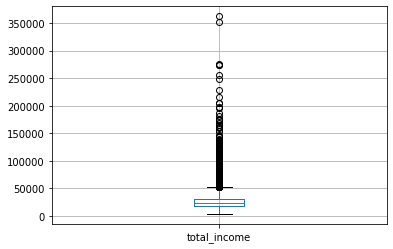

In [89]:
# Quartis da renda
print(df['total_income'].quantile([0.1,0.25,0.5,0.6, 0.85,0.99]))
print()
print(df.boxplot(column=['total_income']))

In [90]:
# Função para categorização em diferentes grupos numéricos com base em intervalos
def income_class(income):
    if income < 17235:
        return 'poor'
    if (income >= 17235) and (income < 25707):
        return 'lower middle class'
    if (income >= 25707) and (income < 37957):
        return 'middle class'
    if (income >= 37957) and (income < 80819):
        return 'high middle class'
    if (income >= 80819):
        return 'rich'

In [91]:
# Coluna com categorias
df['income_class'] = df['total_income'].apply(income_class)
#df['purpose_categories'] = df.apply(purpose_categories, axis=1)

In [92]:
# Valores de cada categoria para ver a distribuição
df['income_class'].value_counts()

lower middle class    7533
middle class          5380
poor                  5379
high middle class     3012
rich                   216
Name: income_class, dtype: int64

## 5. Verificar as Hipóteses <a id='5'></a>

**Existe uma correlação entre a quantidade de filhos e do pagamento em dia?**

[Voltar ao Índice](#back)

In [93]:
# Verificar os dados das crianças e do pagamento em dia
print(df.groupby(['children', 'parents'])['debt'].sum())
print('*'*35)
print(df.groupby(['children', 'parents'])['debt'].count())

children  parents
0         0          1063
1         1           444
2         1           201
3         1            27
4         1             4
5         1             0
Name: debt, dtype: int64
***********************************
children  parents
0         0          14146
1         1           4864
2         1           2130
3         1            330
4         1             41
5         1              9
Name: debt, dtype: int64


In [94]:
# Tabela com informações baseadas em "children"
pivot_children = df.pivot_table(index='children', columns='debt', values='days_employed', aggfunc='count')
pivot_children['defaulter_percent'] = pivot_children[1] / (pivot_children[1] + pivot_children[0])*100
pivot_children.sort_values(by='defaulter_percent')

debt,0,1,defaulter_percent
children,,,
0,13083.0,1063.0,7.514492
3,303.0,27.0,8.181818
1,4420.0,444.0,9.128289
2,1929.0,201.0,9.436620
4,37.0,4.0,9.756098
5,9.0,NaN,NaN


In [95]:
# Tabela com informações baseadas em "parents"
pivot_parents = df.pivot_table(index='parents', columns='debt', values='days_employed', aggfunc='count')
pivot_parents['defaulter_percent'] = pivot_parents[1] / (pivot_parents[1] + pivot_parents[0])*100
pivot_parents.sort_values(by='defaulter_percent')

debt,0,1,defaulter_percent
parents,,,
0,13083,1063,7.514492
1,6698,676,9.167345


**Conclusão**

De acordo com os dados, não ter filhos aumentam ligeiramente suas chances de ser um bom adimplente. A quantidade de filhos não parece influenciar de forma significativa a inadimplência.

[Voltar ao Índice](#back)

**Existe uma correlação entre o status familiar e o pagamento em dia?**

In [96]:
# Verificar os dados de status da família e do pagamento em dia
print(df.groupby('family_status')['debt'].sum())
print('*'*35)
print(df.groupby('family_status')['debt'].count())

family_status
civil partnership    388
divorced              85
married              929
unmarried            274
widow / widower       63
Name: debt, dtype: int64
***********************************
family_status
civil partnership     4175
divorced              1195
married              12378
unmarried             2812
widow / widower        960
Name: debt, dtype: int64


In [97]:
# Tabela com informações baseadas em "family_status"
pivot_status = df.pivot_table(index='family_status', columns='debt', values='days_employed', aggfunc='count')
pivot_status['defaulter_percent'] = pivot_status[1] / (pivot_status[1] + pivot_status[0])*100
pivot_status.sort_values(by='defaulter_percent')

debt,0,1,defaulter_percent
family_status,,,
widow / widower,897,63,6.562500
divorced,1110,85,7.112971
married,11449,929,7.505251
civil partnership,3787,388,9.293413
unmarried,2538,274,9.743954


**Conclusão**

Pessoas solteiras possuem uma propensão ligeiramente superior de inadimplência quando comparamos às pessoas casadas. Viúvos(as) são os que possuem menores índices de inadimplência.

[Voltar ao Índice](#back)

**Existe uma correlação entre o nível de renda e o pagamento em dia?**

In [98]:
# Verificar os dados do nível de renda e do pagamento em dia
print(df.groupby('income_class')['debt'].sum())
print('*'*35)
print(df.groupby('income_class')['debt'].count())

income_class
high middle class     212
lower middle class    652
middle class          436
poor                  425
rich                   14
Name: debt, dtype: int64
***********************************
income_class
high middle class     3012
lower middle class    7533
middle class          5380
poor                  5379
rich                   216
Name: debt, dtype: int64


In [99]:
# Tabela com informações baseadas em "income_class"
pivot_class = df.pivot_table(index='income_class', columns='debt', values='days_employed', aggfunc='count')
pivot_class['defaulter_percent'] = pivot_class[1] / (pivot_class[1] + pivot_class[0])*100
pivot_class.sort_values(by='defaulter_percent')

debt,0,1,defaulter_percent
income_class,,,
rich,202,14,6.481481
high middle class,2800,212,7.038513
poor,4954,425,7.901097
middle class,4944,436,8.104089
lower middle class,6881,652,8.655250


**Conclusão**

Conforme a divisão de classes em `total_income` que produziu a variável `income_class`, temos que o nível de inadimplência não varia tanto entre as classes. Apesar dos ricos e da classe média alta estarem com os melhores índices de adimplência.

[Voltar ao Índice](#back)

**Como a finalidade do crédito afeta a taxa de inadimplência?**

In [100]:
# Verificar os dados da finalidade de crédito e do pagamento em dia
print(df.groupby('purpose_categories')['debt'].sum())
print('*'*35)
print(df.groupby('purpose_categories')['debt'].count())

purpose_categories
car          402
education    370
house        781
wedding      186
Name: debt, dtype: int64
***********************************
purpose_categories
car           4314
education     4022
house        10836
wedding       2348
Name: debt, dtype: int64


In [101]:
# Tabela com informações baseadas em "purpose_categories"
pivot_purpose = df.pivot_table(index='purpose_categories', columns='debt', values='days_employed', aggfunc='count')
pivot_purpose['defaulter_percent'] = pivot_purpose[1] / (pivot_purpose[1] + pivot_purpose[0])*100
pivot_purpose.sort_values(by='defaulter_percent')

debt,0,1,defaulter_percent
purpose_categories,,,
house,10055,781,7.207457
wedding,2162,186,7.921635
education,3652,370,9.199403
car,3912,402,9.318498


**Conclusão**

Os empréstimos com finalidade imobiliária, em sua maioria para aquisição de imóvel, possuem as menores taxas de inadimplência do conjunto de dados. Isso deve-se a garantia de crédito vinculada aos empréstimos imobiliários, uma vez que os imóveis podem ser liquidados para quitação desses mesmos empréstimos.

Porém, os empréstimos com finalidade de adquirir carros são os com maiores taxas de inadimplência, apesar da garantia do crédito ser o próprio carro, há uma depreciação enorme sobre o valor do bem, que muitas vezes mesmo após a liquidação do veículo, o dinheiro remanescente ainda é inferior ao saldo devedor do empréstimo contratado.

Empréstimos para educação e casamento não possuem garantias associadas, porém, este último, geralmente conta com a renda de duas pessoas para pagar as parcelas do empréstimo. Deixando assim, os empréstimos para educação com um dos índices mais altos de inadimplência junto com os empréstimos para aquisição de carros.

[Voltar ao Índice](#back)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21520 entries, 0 to 21524
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   children            21520 non-null  int64  
 1   days_employed       21520 non-null  int64  
 2   dob_years           21520 non-null  int64  
 3   education           21520 non-null  object 
 4   education_id        21520 non-null  int64  
 5   family_status       21520 non-null  object 
 6   family_status_id    21520 non-null  int64  
 7   gender              21520 non-null  object 
 8   income_type         21520 non-null  object 
 9   debt                21520 non-null  int64  
 10  total_income        21520 non-null  float64
 11  purpose             21520 non-null  object 
 12  age_group           21520 non-null  object 
 13  parents             21520 non-null  int64  
 14  purpose_categories  21520 non-null  object 
 15  income_class        21520 non-null  object 
dtypes: f

## 6. Conclusão Geral <a id='6'></a>

Primeiramente foi iniciada a exploração dos dados, no qual foi possível ver os dados discrepantes e perceber a ausência de alguns valores nas variáveis. Após essa análise superficial, foi elencado as principais alterações que deveriam ser realizadas nas varáveis para que se consiga responder as questões propostas.

Ausência de valores, valores negativos, valores extremos e duplicatas explícitas e implícitas foram alguns dos problemas encontrados. Algumas suposições foram criadas, como por exemplo que os valores com idade igual a zero deviam ser por tratar-se de clientes que ainda não tinham atingido um ano de vida, porém conforme avançava na análise, entendeu-se que outras variáveis não corroboravam com a ideia inicial, como o fato desse cliente ter filho ou ser formado, por exemplo.

Os valores ausentes estavam concentrados e correlacionados com as variáveis de renda e dias de trabalho, possuíam as mesmas linhas com valores ausentes. Como esses valores ausentes correspondiam a 10.09% dos dados, decidiu-se por preenchê-los. Os valores ausentes não possuíam um padrão observável para sua existência na base de dados.

Os valores negativos foram tratados como valores absolutos, pois não há como tratar filhos negativos ou dias trabalhados negativos.

Em `days_employed` temos valores ausentes, números extremos — dias de trabalho que superam os dias de vida dos clientes —, bem como números negativos (não há dias trabalhados negativos). Esse percentual de valores negativos atinge 73.9% dos dados em dias trabalhados. Já a porcentagem de dias trabalhados que superam a idade do cliente é 16.00%.

Foi verificado que os clientes com informações de dias trabalhados que superam seus dias de vida estão concentrados, em sua totalidade, no grupo `retiree`. Foi utilizado a fórmula (`dob_years` - 18)*365 para substituir esses valores, baseados nos critérios do mercado de trabalho norte americano.

As 71 linhas duplicadas não foram tratadas por não haver indicações nos dados de que realmente os dados são dos mesmos clientes, uma vez que não temos um id_client.

Para manipular dados e responder as questões propostas, fez-se necessário categorizar a idade dos clientes em grupos. A categorização na motivação para conseguir empréstimo também foi realizada, já que havia duplicatas implícitas na variável `purpose`. Grupo de classes sociais foi categorizado e criado através da variável de renda, segundo os critérios da _Bureau of Economic Analysis_.

As variáveis que representam o tipo de trabalho `income_type`, nível educacional `education` e gênero `gender` influenciam a renda do indivíduo e foram utilizadas para preencher os valores ausentes em `total_income`.

Como a variável `total_income` possui valores com grande variação entre mínimo e máximo, a literatura sugere a utilização da mediana para atenuar os valores extremos. A média ficaria muito influenciada por esses valores discrepantes.

Grupo de idade, gênero e tipo de renda foram utilizados para preencher os valores ausentes em dias de trabalho `days_employed`.

As principais conclusões foram:

* Existe uma correlação entre a quantidade de filhos e do pagamento em dia?
De acordo com os dados, não ter filhos aumentam ligeiramente suas chances de ser um bom adimplente. A quantidade de filhos não parece influenciar de forma significativa a inadimplência.

* Existe uma correlação entre o status familiar e o pagamento em dia?
Pessoas solteiras possuem uma propensão ligeiramente superior de inadimplência quando comparamos às pessoas casadas. Viúvos(as) são os que possuem menores índices de inadimplência.

* Existe uma correlação entre o nível de renda e o pagamento em dia?
Conforme a divisão de classes em `total_income` que produziu a variável `income_class`, temos que o nível de inadiplência não varia tanto entre as classes. Apesar dos ricos e da classe média alta estarem com os melhores índices de adimplência.

* Como a finalidade do crédito afeta a taxa de inadimplência?
Os empréstimos com finalidade imobiliária, em sua maioria para aquisição de imóvel, possuem as menores taxas de inadimplência do conjunto de dados. Isso deve-se a garantia de crédito vinculada aos empréstimos imobiliários, uma vez que os imóveis podem ser liquidados para quitação desses mesmos empréstimos.

Porém, os empréstimos com finalidade de adquirir carros são os com maiores taxas de inadimplência, apesar da garantia do crédito ser o próprio carro, há uma depreciação enorme sobre o valor do bem, que muitas vezes mesmo após a liquidação do veículo, o dinheiro remanescente ainda é inferior ao saldo devedor do empréstimo contratado.

Empréstimos para educação e casamento não possuem garantias associadas, porém, este último, geralmente conta com a renda de duas pessoas para pagar as parcelas do empréstimo. Deixando assim, os empréstimos para educação com um dos índices mais altos de inadimplência junto com os empréstimos para aquisição de carros.

[Voltar ao Índice](#back)


## 7. REFERÊNCIAS <a id='end'></a>

* Bureau of Economic Analysis: Acesso em 20 de novmebro de 2022, em https://www.bea.gov/news/2022/personal-income-and-outlays-september-2022

* Center for Disease Control and Prevention: Acesso em 19 de novembro de 2022, em https://www.cdc.gov/nchs/hus/sources-definitions/marital-status.htm

* Statistique Canada: Acesso em 20 de nomvembro de 2022, em https://www.statcan.gc.ca/en/concepts/definitions/age2

